# Country Categorization Analysis

## Step 1: Gather data, determine the method of data collection and provenance of the data (3 points)

The dataset used was downloaded from Kaggle: https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data/data

(The data used doesn't look like is real and the scenario used might be hypothethical)


## Step 2: Identify an Unsupervised Learning Problem (6 points)

The main goal with this dataset is to categorise the countries using socio-economic and health factors that determine the overall development of the country. This is a typical clustering problem trying to find structures or groups in the data based on similarities without having a target variable.

Socio economic and health factors are usually continuous or ordinal variables, suitable for clustering algorithms like K-Means, Hierarchical Clustering, DBSCAN, etc. In this case we will use K-Means

The output from the clustering model will be used to make informed decisions on where to allocate potential resources. For example, countries in clusters characterized by low GDP, poor health indicators, and high poverty rates might be prioritized for aid.

## Step 3: Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data (26 points)

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from folium.plugins import HeatMap
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules


# Define the path to the CSV file
file_path = './data/Country-data.csv'

# Load the CSV file directly into a DataFrame
country_data  = pd.read_csv(file_path)


#### Lets check the shape of the data and first few entries

In [2]:
print("Data Information:")
country_data .info()

print("\nFirst 5 Entries in Data:")
print(country_data .head())

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB

First 5 Entries in Data:
               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3       

##### Here are a few insights from the data:
- Total Entries: 167 countries.
- Variables: It contains 10 columns.
- There are no null values in the dataset, which is a good start. The next steps in the analysis would typically include:

##### Proceeding into the EDA since the data looks clean and no null values are present here we will:
- Visualize the distributions of numerical variables.
- Create correlation plots to understand relationships between variables.
- Identify potential outliers.

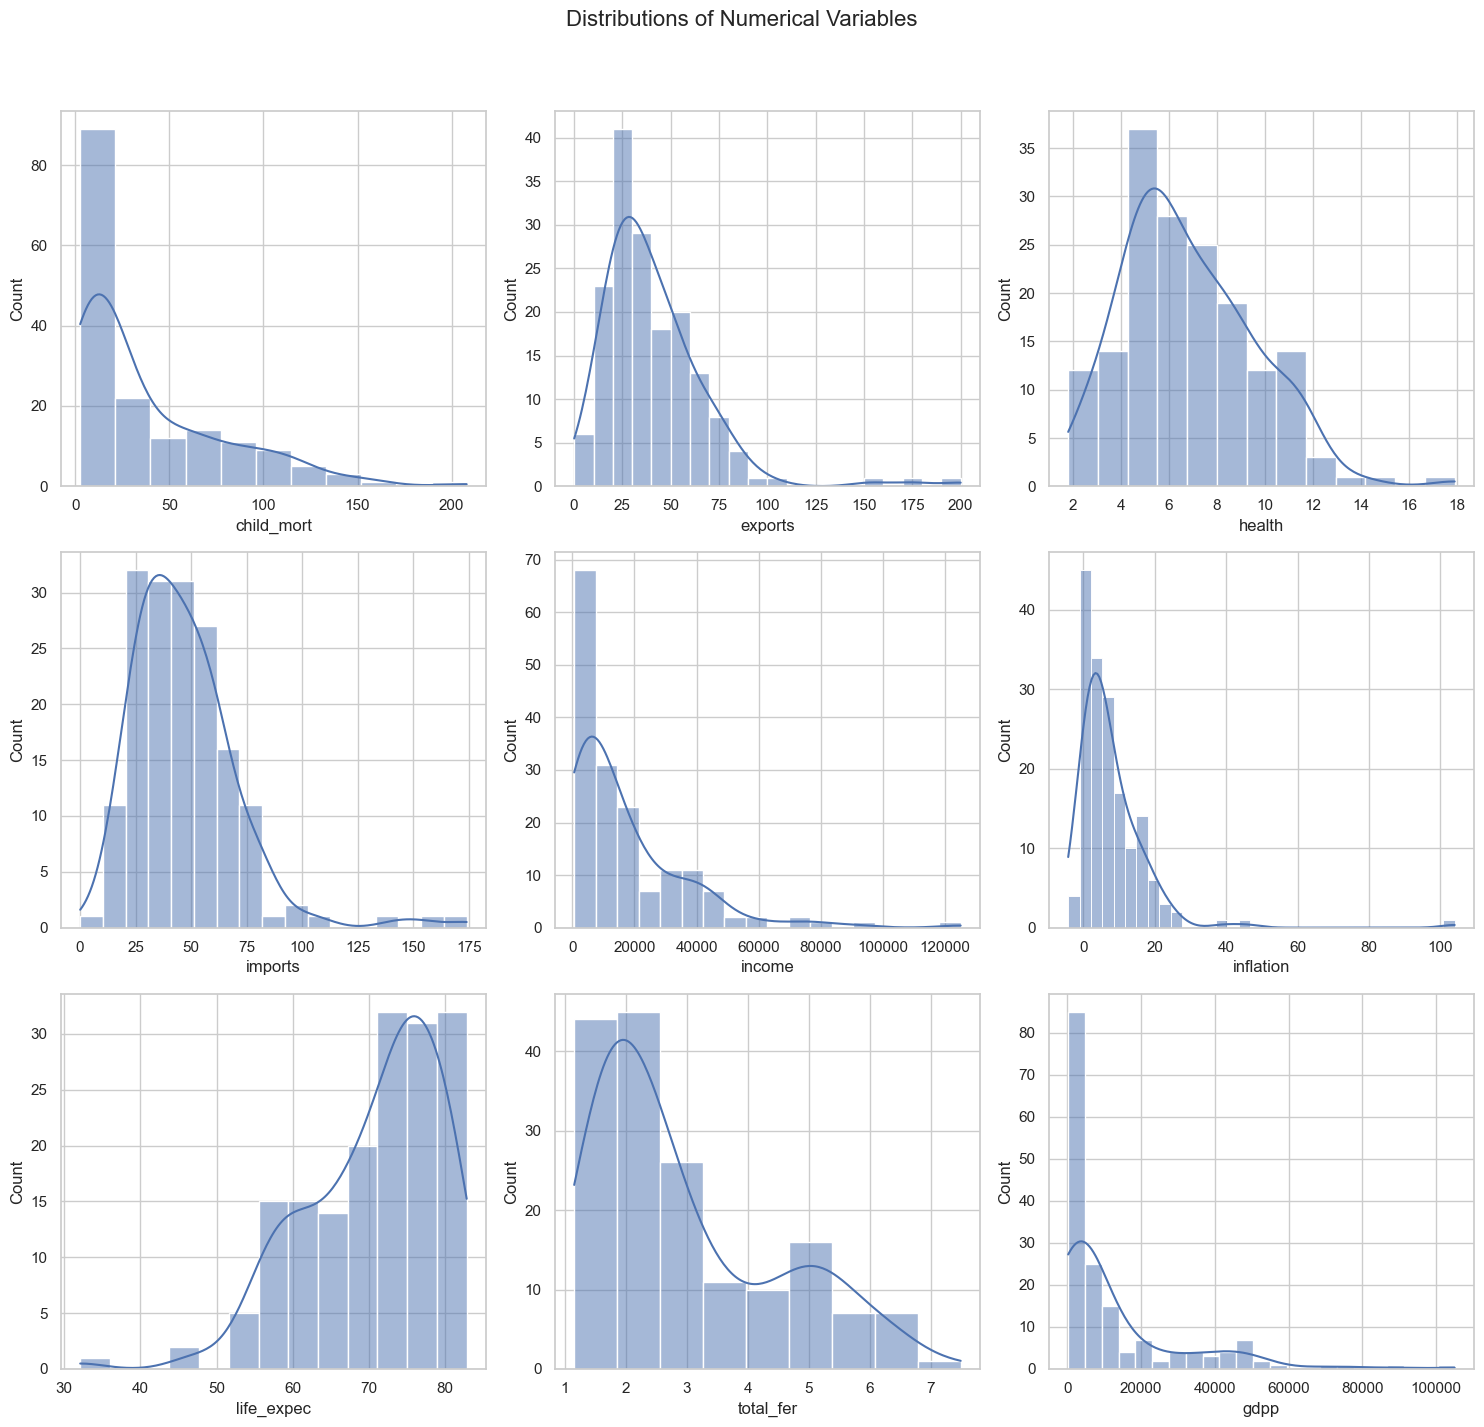

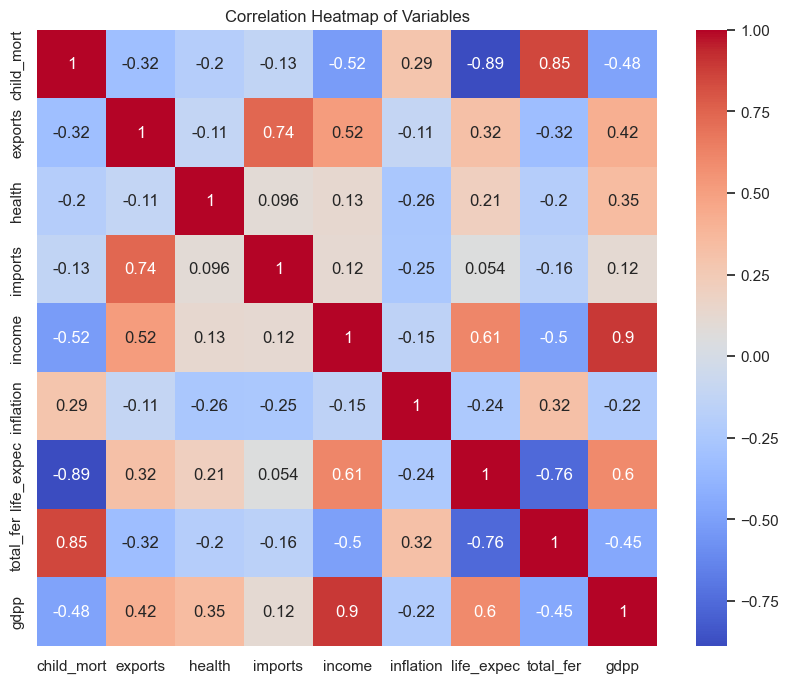

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the aesthetics for the plots
sns.set(style="whitegrid")

# Plotting distributions of numerical variables
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
fig.suptitle('Distributions of Numerical Variables', fontsize=16)

# List of numerical columns for plotting
num_cols = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

# Creating distribution plots
for i, col in enumerate(num_cols):
    sns.histplot(country_data[col], kde=True, ax=axes[i//3, i%3])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Creating a correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(country_data[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Variables')

plt.show()



### **EDA Analsyis**

#### **Distribution Plots**

**Child Mortality (child_mort):**
This variable shows a right skewed distribution, indicating that a majority of countries have lower child mortality rates, but there is a significant number of countries with very high rates.This skewness suggests a divide between countries with better and poorer child health conditions.

**Exports, Health, and Imports (as % of GDP):**

These variables show varied distributions. Most countries have moderate percentages, but there are outliers with extremely high or low values.

**Income (income):**
The income distribution is also right skewed, indicating that most countries have a lower income per person, but a few countries have very high income levels. This variable is crucial for understanding economic disparities among countries.

**Inflation (inflation):**
Exhibits a wide spread with some countries experiencing very high inflation rates. This can be a critical factor influencing the economic stability of a country.

**Life Expectancy (life_expec):**
Shows a left skewed distribution, where most countries have a high life expectancy, but some countries lag significantly behind.

**Total Fertility (total_fer) and GDP per Capita (gdpp):**
total_fer is somewhat right skewed, indicating variations in birth rates across countries.
gdpp is highly right-skewed, showing large discrepancies in economic wealth.

#### **Correlation Heatmap**

**Income and GDP per Capita (income and gdpp):**
Strongly positively correlated. This indicates that countries with higher income levels generally have a higher GDP per capita.

**Child Mortality and Life Expectancy (child_mort and life_expec):**
Strongly negatively correlated. Higher child mortality rates are associated with lower life expectancies, which makes sense as both are indicators of a country's health status.

**GDP per Capita and Health Expenditure (gdpp and health):**
Moderately positively correlated. Countries with higher GDP per capita tend to spend more on health, reflecting better health care systems.

**Fertility Rate and Life Expectancy (total_fer and life_expec):**
Negatively correlated. Higher fertility rates often correlate with lower life expectancies, possibly due to factors like inadequate health care facilities.

**Income and Child Mortality (income and child_mort):**
Negatively correlated. Higher income levels in a country correlate with lower child mortality rates, suggesting better living conditions and healthcare.

## Step 4: Perform Analysis Using Unsupervised Learning Models of your Choice, Present Discussion, and Conclusions (70 points)

### Normalization and K-Means implementation
I will start by normalizing the data. Since there is a mix of different scales like percentage, counts, and monetary values, normalization will ensure that one feature doesn't dominate the clustering process simply because of its scale. After normalization, I will apply the K-Means algorithm and use the Elbow Method to find the optimal number of clusters.

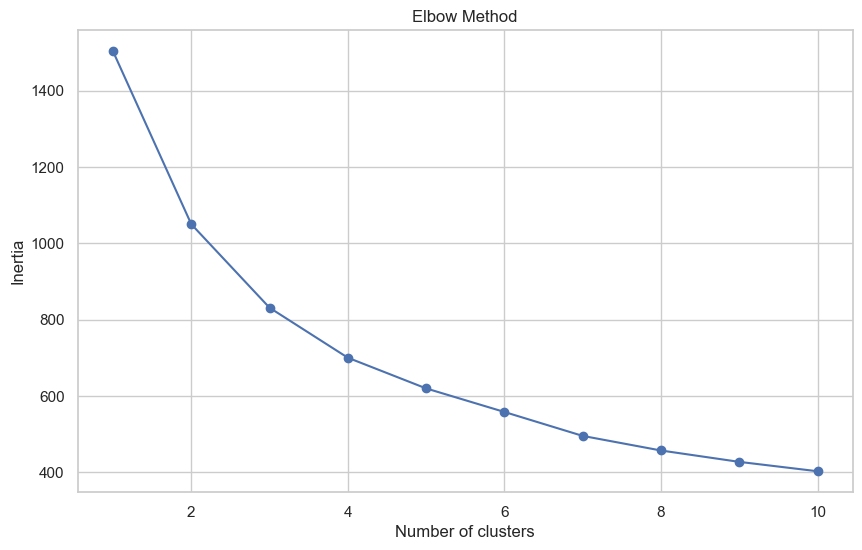

In [4]:
#Normalization

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Dropping the 'country' column for clustering as it's a categorical variable
clustering_data = country_data.drop('country', axis=1)

# Standardizing/Normalizing the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

# Using the Elbow Method to find the optimal number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


From the Elbow plot, it's a bit challenging to pinpoint the exact point when the curve is somewhat gradual. I could say that a potential elbow seems to appear around 3 to 5 clusters. With that said, I will go ahead an test K-Means with all three clusters and choose the best based on the results

In [5]:
#K-Means clustering and return cluster labels
def perform_kmeans(n_clusters, data):
    kmeans = KMeans(n_clusters=n_clusters,n_init='auto', random_state=42)
    kmeans.fit(data)
    return kmeans.labels_

# Performing K-Means clustering for 3, 4, and 5 clusters
labels_3_clusters = perform_kmeans(3, scaled_data)
labels_4_clusters = perform_kmeans(4, scaled_data)
labels_5_clusters = perform_kmeans(5, scaled_data)

# Adding the cluster labels back to the original dataframe for analysis
country_data['Cluster_3'] = labels_3_clusters
country_data['Cluster_4'] = labels_4_clusters
country_data['Cluster_5'] = labels_5_clusters

# Displaying the first few rows of the dataframe with cluster labels
country_data.head()


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster_3,Cluster_4,Cluster_5
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,2,2,2
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0,0,0
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,0,0,0
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,2,2,2
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0,0,0


Now we check the centroids of the clusters to analyze which cluster option we should select

In [6]:
# Adjusted function to include cluster labels in the analysis
def cluster_analysis(data, cluster_col):
    # Ensuring that the cluster label column is included in the analysis
    numeric_data = data.select_dtypes(include=['float64', 'int64', 'int32'])
    numeric_data[cluster_col] = data[cluster_col]

    # Calculating cluster centroids for numeric columns only
    centroids = numeric_data.groupby(cluster_col).mean()

    # Calculating cluster sizes
    cluster_sizes = data[cluster_col].value_counts().sort_index()

    return centroids, cluster_sizes

# Re-analyzing clusters for 3, 4, and 5 cluster solutions with the revised function
centroids_3, sizes_3 = cluster_analysis(country_data, 'Cluster_3')
centroids_4, sizes_4 = cluster_analysis(country_data, 'Cluster_4')
centroids_5, sizes_5 = cluster_analysis(country_data, 'Cluster_5')

centroids_3, sizes_3, centroids_4, sizes_4, centroids_5, sizes_5



(           child_mort    exports    health    imports        income  \
 Cluster_3                                                             
 0           22.456977  40.273128  6.251047  47.362394  12321.744186   
 1            5.000000  58.738889  8.807778  51.491667  45672.222222   
 2           95.106667  28.602444  6.301111  42.306667   3539.844444   
 
            inflation  life_expec  total_fer          gdpp  Cluster_4  \
 Cluster_3                                                              
 0           7.720884   72.566279   2.340349   6461.767442   0.000000   
 1           2.671250   80.127778   1.752778  42494.444444   1.000000   
 2          11.986778   59.055556   5.065333   1766.711111   2.022222   
 
            Cluster_5  
 Cluster_3             
 0           0.011628  
 1           1.194444  
 2           2.022222  ,
 Cluster_3
 0    86
 1    36
 2    45
 Name: count, dtype: int64,
            child_mort    exports    health    imports        income  \
 Cluster_4  

### Cluster Selection Analysis

#### **3-Cluster Solution**
- Cluster 0: Moderate child mortality, moderate income, and life expectancy. It posibly represents countries with intermediate socio economic status. (86 countries)
- Cluster 1: Low child mortality, high income, and life expectancy. It posibly represents more developed countries. (36 countries)
- Cluster 2: High child mortality, low income, and lower life expectancy. It posibly represents less developed countries. (45 countries)
  
#### **4-Cluster Solution**
- Cluster 0: Similar to Cluster 0 in the 3 cluster solution, with intermediate socio economic status. (86 countries)
- Cluster 1: Similar to Cluster 1 in the 3 cluster solution, more developed countries. (36 countries)
- Cluster 2: Similar to Cluster 2 in the 3 cluster solution, less developed countries. (44 countries)
- Cluster 3: An outlier cluster with extremely high inflation, low income, and low life expectancy. (1 country)
  
#### **5-Cluster Solution**
- Cluster 0: Moderate child mortality, moderate income, and life expectancy. Similar to Cluster 0 in previous solutions. (87 countries)
- Cluster 1: Low child mortality, high income, and life expectancy. Similar to more developed countries in previous solutions. (32 countries)
- Cluster 2: High child mortality, low income, and lower life expectancy. Similar to less developed countries in previous solutions. (44 countries)
- Cluster 3: An outlier with extremely high inflation, low income, and low life expectancy. (1 country)
- Cluster 4: Very high-income countries with extremely high GDP, very high life expectancy, and very low child mortality. (3 countries)
  
#### **Selection**
Because the main goal of the project is to make informed decisions on where to allocate potential resources, more granularity is better so we will choose the 5 cluster solution

## **Cluster 5 solution detailed**

In [7]:
# Extracting the centroids for the 5-cluster solution
centroids_5_clusters = centroids_5

# Displaying the centroids for each cluster in the 5-cluster solution
centroids_5_clusters

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster_3,Cluster_4
Cluster_5,,,,,,,,,,,
0,22.219540,41.083782,6.246667,47.795010,12678.965517,7.727747,72.625287,2.333333,6494.390805,0.022989,0.022989
1,5.181250,46.118750,9.088437,40.584375,44021.875000,2.513844,80.081250,1.788437,42118.750000,0.968750,0.968750
2,94.313636,28.677500,6.329091,42.872727,3503.250000,9.895568,59.022727,5.047727,1753.909091,2.000000,2.000000
3,130.000000,25.300000,5.070000,17.400000,5150.000000,104.000000,60.500000,5.840000,2330.000000,2.000000,3.000000
4,4.133333,176.000000,6.793333,156.666667,64033.333333,2.468000,81.433333,1.380000,57566.666667,1.000000,1.000000


### **Cluster 0 (Highly Challenged)**
- Child Mortality: Moderate (22.22 per 1000)
- Income: Moderate ($12,678)
- Life Expectancy: Good (72.63 years)
- GDP per Capita: Moderate ($6,494)
- Other Factors: Moderate inflation and fertility rate; moderate levels of exports and imports.
### **Cluster 1 (Most Developed)**
- Child Mortality: Very Low (5.18 per 1000)
- Income: Very High ($44,021)
- Life Expectancy: Very High (80.08 years)
- GDP per Capita: Very High ($42,118)
- Other Factors: Low inflation, low fertility rate; moderate levels of exports and imports.
### **Cluster 2 (Moderately Developed)**
- Child Mortality: High (94.31 per 1000)
- Income: Low ($3,503)
- Life Expectancy: Lower (59.02 years)
- GDP per Capita: Low ($1,753)
- Other Factors: High inflation, high fertility rate; lower levels of exports and imports.
### **Cluster 3 (Outlier with High Inflation)**
- Child Mortality: Extremely High (130 per 1000)
- Income: Low ($5,150)
- Life Expectancy: Low (60.5 years)
- GDP per Capita: Low ($2,330)
- Other Factors: Extremely high inflation; very low levels of exports and imports.
### **Cluster 4 (Ultra Developed)**
- Child Mortality: Very Low (4.13 per 1000)
- Income: Ultra High ($64,033)
- Life Expectancy: Highest (81.43 years)
- GDP per Capita: Ultra High ($57,566)
- Other Factors: Very low inflation, lowest fertility rate; extremely high levels of exports and imports.

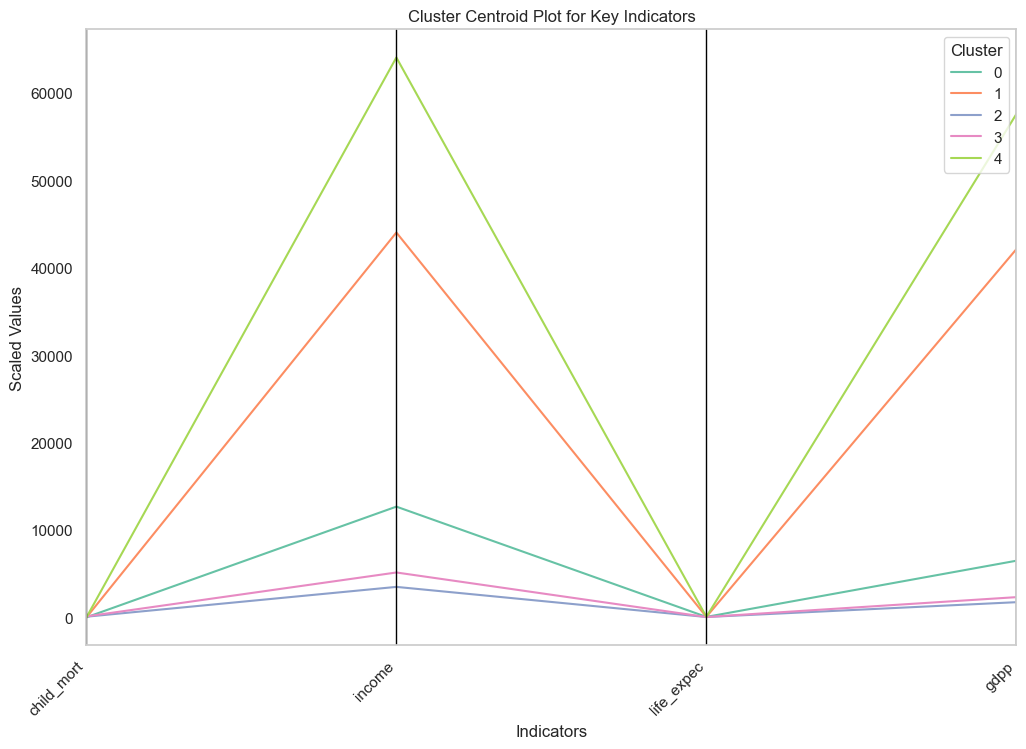

In [8]:
# Selecting key indicators for the cluster centroid plot
key_indicators = ['child_mort', 'income', 'life_expec', 'gdpp']

# Extracting centroids for key indicators
key_centroids = centroids_5_clusters[key_indicators]

# Resetting the index of the centroids DataFrame to use it in the parallel_coordinates plot
key_centroids_reset = key_centroids.reset_index()

# Creating the Cluster Centroid Plot again
plt.figure(figsize=(12, 8))
parallel_coordinates = pd.plotting.parallel_coordinates(key_centroids_reset, class_column='Cluster_5', color=sns.color_palette("Set2", 5))
plt.title('Cluster Centroid Plot for Key Indicators')
plt.xlabel('Indicators')
plt.ylabel('Scaled Values')
plt.xticks(rotation=45)
plt.legend(title='Cluster', loc='upper right')

# Enhancing the plot's readability
for label in parallel_coordinates.get_xticklabels():
    label.set_horizontalalignment('right')

plt.show()



Finally we will list and identify the countries that fall into each of these clusters. This will help in understanding which specific countries share similar socio economic and health profiles.

In [9]:
# Creating a dictionary to hold the countries in each cluster for the 5-cluster solution
countries_in_5_clusters = {cluster: list(country_data[country_data['Cluster_5'] == cluster]['country']) 
                           for cluster in range(5)}

# Displaying the countries in each cluster for the 5-cluster solution
countries_in_5_clusters



{0: ['Albania',
  'Algeria',
  'Antigua and Barbuda',
  'Argentina',
  'Armenia',
  'Azerbaijan',
  'Bahrain',
  'Bangladesh',
  'Barbados',
  'Belarus',
  'Belize',
  'Bhutan',
  'Bolivia',
  'Bosnia and Herzegovina',
  'Botswana',
  'Brazil',
  'Bulgaria',
  'Cambodia',
  'Cape Verde',
  'Chile',
  'China',
  'Colombia',
  'Costa Rica',
  'Croatia',
  'Dominican Republic',
  'Ecuador',
  'Egypt',
  'El Salvador',
  'Estonia',
  'Fiji',
  'Georgia',
  'Grenada',
  'Guatemala',
  'Guyana',
  'Hungary',
  'India',
  'Indonesia',
  'Iran',
  'Iraq',
  'Jamaica',
  'Jordan',
  'Kazakhstan',
  'Kyrgyz Republic',
  'Latvia',
  'Lebanon',
  'Libya',
  'Lithuania',
  'Macedonia, FYR',
  'Malaysia',
  'Maldives',
  'Mauritius',
  'Micronesia, Fed. Sts.',
  'Moldova',
  'Mongolia',
  'Montenegro',
  'Morocco',
  'Myanmar',
  'Nepal',
  'Oman',
  'Panama',
  'Paraguay',
  'Peru',
  'Philippines',
  'Poland',
  'Romania',
  'Russia',
  'Samoa',
  'Saudi Arabia',
  'Serbia',
  'Seychelles',
  'Slo

## Conclusion


After using K-Means to cluster the countries based on their characteristics and features in order to be able to identify locations where aid is needed, we can conclude that:
- Clusters 2 and 3, representing the least developed and outlier countries, should be prioritized for international aid and development programs. These countries require focused interventions in health, education, and economic development.
- Countries in Clusters 1 and 4 can serve as benchmarks for successful policies and practices. Collaborations and learning from these countries can provide valuable insights for others.
- For countries in Cluster 0, a balanced approach is needed. While they have achieved moderate development, there is room for improvement, specially in bridging the gap to reach the standards of the most developed clusters.

For organizations that would like to provide aid and support, this information is vital in strategically directing resources and efforts where they are most needed and in formulating policies that cater to the unique contexts of different country groups.